# Isolation forests

Running an [isolation forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html) on the SAMueL data to identify anomalies vs. normal data in the real data, and then comparing the results with synthetic data to pick out synthetic points that lie too close to "normal" real data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.ensemble import IsolationForest

In [3]:
from calculate_accuracy import calculate_accuracy
from scale_data import scale_data

/home/anna/miniconda3/envs/pytorch/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


---

## Import the SAMueL data

In [4]:
data_loc = '../ssnap_data/data/kfold_5fold/'

Each kfold length of data (number of rows): ~71,000 for train, ~18,000 for test

In [5]:
# Initialise empty lists
train_data, test_data = [], []

# Read in the names of the selected features for the model
number_of_features_to_use = 8
# key_features = pd.read_csv('./output/feature_selection.csv')
# key_features = list(key_features['feature'])[:number_of_features_to_use]
key_features = [
    'S2BrainImagingTime_min',              # Arrival-to-scan time
    'S2StrokeType_Infarction',             # Infarction
    'S2NihssArrival',                      # 'Stroke severity'
    'S1OnsetTimeType_Precise',             # (1=precise, 0=best estimate)
    'S2RankinBeforeStroke',                # Prior disability level
    'AFAnticoagulent_Yes',                 # Use of AF anticoagulents
    'S1OnsetToArrival_min',                # Onset-to-arrival time 
    # 'StrokeTeam',                          # Stroke team, 
    'S1OnsetDateType_Stroke during sleep', # (1=yes, 0=no)
    'S1AgeOnArrival'                       # Patient age
    ]
# And add the target feature name: S2Thrombolysis
key_features.append("S2Thrombolysis")

for i in range(5):
    train = pd.read_csv(data_loc + 'train_{0}.csv'.format(i))
    train = train[key_features]#[:2000]
    # train.rename(columns=feature_name_dict, inplace=True)
    train_data.append(train)
    
    test = pd.read_csv(data_loc + 'test_{0}.csv'.format(i))
    test = test[key_features]#[:1000]
    # test.rename(columns=feature_name_dict, inplace=True)
    test_data.append(test)

Split into X and y:

In [6]:
X_train = train_data[0].drop(['S2Thrombolysis'], axis=1).values
y_train = train_data[0]['S2Thrombolysis'].values

X_test = test_data[0].drop(['S2Thrombolysis'], axis=1).values
y_test = test_data[0]['S2Thrombolysis'].values

for i in range(1,5):
    X_train = np.concatenate((X_train, train_data[i].drop(['S2Thrombolysis'], axis=1).values))
    y_train = np.concatenate((y_train, train_data[i]['S2Thrombolysis'].values))
    
    X_test = np.concatenate((X_test, test_data[i].drop(['S2Thrombolysis'], axis=1).values))
    y_test = np.concatenate((y_test, test_data[i]['S2Thrombolysis'].values))

Standardise X:

In [7]:
X_train_sc, X_test_sc = scale_data(X_train, X_test)

---

## Import synthetic data 

In [8]:
synth_loc = '/home/anna/samuel_book/samuel_shap_paper_1/synthetic_patients/data/kfold_5fold/'

Each kfold length of data (number of rows): ~105,000 for train, ~26,000 for test

In [9]:
# Initialise empty lists
train_synth, test_synth = [], []

for i in range(5):
    train = pd.read_csv(synth_loc + 'train_{0}.csv'.format(i))
    train = train[key_features]#[:2000]
    # train.rename(columns=feature_name_dict, inplace=True)
    train_synth.append(train)
    
    test = pd.read_csv(synth_loc + 'test_{0}.csv'.format(i))
    test = test[key_features]#[:1000]
    # test.rename(columns=feature_name_dict, inplace=True)
    test_synth.append(test)

Split into X and y:

In [10]:
X_train_synth = train_synth[0].drop(['S2Thrombolysis'], axis=1).values
y_train_synth = train_synth[0]['S2Thrombolysis'].values

X_test_synth = test_synth[0].drop(['S2Thrombolysis'], axis=1).values
y_test_synth = test_synth[0]['S2Thrombolysis'].values

for i in range(1,5):
    X_train_synth = np.concatenate((X_train_synth, train_synth[i].drop(['S2Thrombolysis'], axis=1).values))
    y_train_synth = np.concatenate((y_train_synth, train_synth[i]['S2Thrombolysis'].values))
    
    X_test_synth = np.concatenate((X_test_synth, test_synth[i].drop(['S2Thrombolysis'], axis=1).values))
    y_test_synth = np.concatenate((y_test_synth, test_synth[i]['S2Thrombolysis'].values))

Standardise X:

In [11]:
X_train_synth_sc, X_test_synth_sc = scale_data(X_train_synth, X_test_synth)

---

# The isolation forest

Set up the forest:

In [12]:
# Classifier clf: 
clf = IsolationForest(
    n_estimators=1000,
    # max_samples=256,
    contamination=0.01,
    n_jobs=-1,
    random_state=42
    )

## Training data

Fit to the training data and also return the predicted labels: 

In [13]:
X_train_labels = clf.fit_predict(X_train_sc)

Check the proportion of anomalies in the training data: 

In [32]:
def find_proportion_of_anomalies(labels):
    """
    Labels are +1 for normal data and -1 for anomalies. 
    """
    total = len(labels)
    total_anom = len(np.where(labels==-1)[0])
    
    print(f'{100.0*total_anom / total:4.2f}% are anomalies ' +
          f'({total_anom} of {total} values).')
    return total_anom / total

In [33]:
X_train_prop_anom = find_proportion_of_anomalies(X_fit_labels)

1.00% are anomalies (3552 of 355168 values).


## Test data

Use the isolation forest to pick out anomalies: 

In [16]:
X_test_labels = clf.predict(X_test_sc)

In [34]:
X_test_prop_anom = find_proportion_of_anomalies(X_test_labels)

1.00% are anomalies (888 of 88792 values).


## Anomaly scores

As well as returning a label of anomaly vs. normal data, the forest can give each row of the data an anomaly score.

This returned score is 1 minus the anomaly score from Liu et al. 2008. 

__To do:__ write up exactly how anomaly score relates to path length

In [18]:
X_train_sc_anom_score = clf.decision_function(X_train_sc)

In [19]:
X_test_sc_anom_score = clf.decision_function(X_test_sc)

Plotting these scores as a histogram, the range of values is exactly the same for the training and test sets. It's a bit suspicious.

(n.b. the histograms are normalised. The sum of (bin height x bin width) for all bins is 1. The bin heights can go above 1 because the bin widths are so small.)

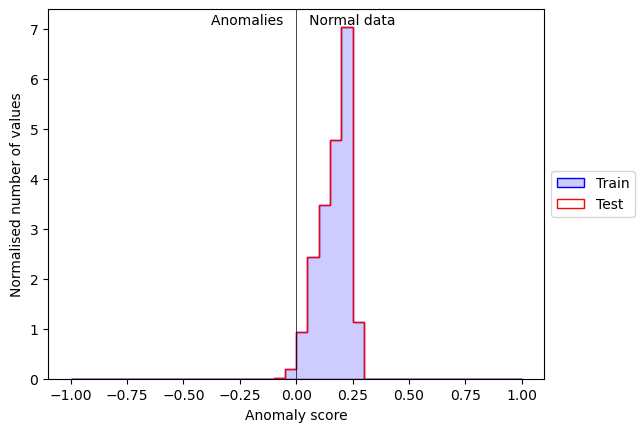

In [20]:
fig, ax = plt.subplots(1, 1) 

bins = np.arange(-1.0, 1.01, 0.05)

ax.hist(X_train_sc_anom_score, bins, density=True, 
        histtype='stepfilled', #hatch='//', 
        color=(0, 0, 1, 0.2), edgecolor=(0, 0, 1, 1),
        label='Train'
       )
ax.hist(X_test_sc_anom_score, bins, density=True, 
        histtype='step', #hatch='\\\\',
        color=(1, 0, 0, 0.2), edgecolor=(1, 0, 0, 1),
        label='Test'
       )

ax.axvline(0.0, color='k', linewidth=0.5)
ax.set_xlabel('Anomaly score')
ax.set_ylabel('Normalised number of values') 
ax.annotate('Anomalies   ', xy=(0.0, ax.get_ylim()[1]*0.95), 
            ha='right', va='bottom') 
ax.annotate('   Normal data', xy=(0.0, ax.get_ylim()[1]*0.95), 
            ha='left', va='bottom') 
ax.legend(loc='center left', bbox_to_anchor=[1.0, 0.5])
plt.show()

Separate out the anomalies:

In [109]:
# Use the labels from the scaled data to sample the not-scaled data 
# (no "sc" in variable name):
norm_train = X_train[np.where(X_train_labels==+1)]
anom_train = X_train[np.where(X_train_labels==-1)]

## Synthetic data

### Labels

Label the anomalies for training and test data:

In [21]:
X_train_synth_labels = clf.predict(X_train_synth_sc)

In [35]:
X_train_synth_prop_anom = find_proportion_of_anomalies(X_train_synth_labels)

0.86% are anomalies (4532 of 527928 values).


In [23]:
X_test_synth_labels = clf.predict(X_test_synth_sc)

In [36]:
X_test_synth_prop_anom = find_proportion_of_anomalies(X_test_synth_labels)

0.86% are anomalies (1133 of 131982 values).


### Anomaly scores

In [25]:
X_train_synth_sc_anom_score = clf.decision_function(X_train_synth_sc)

In [26]:
X_test_synth_sc_anom_score = clf.decision_function(X_test_synth_sc)

Plotting these scores as a histogram, the range of values is exactly the same for the training and test sets. It's a bit suspicious.

(n.b. the histograms are normalised. The sum of (bin height x bin width) for all bins is 1. The bin heights can go above 1 because the bin widths are so small.)

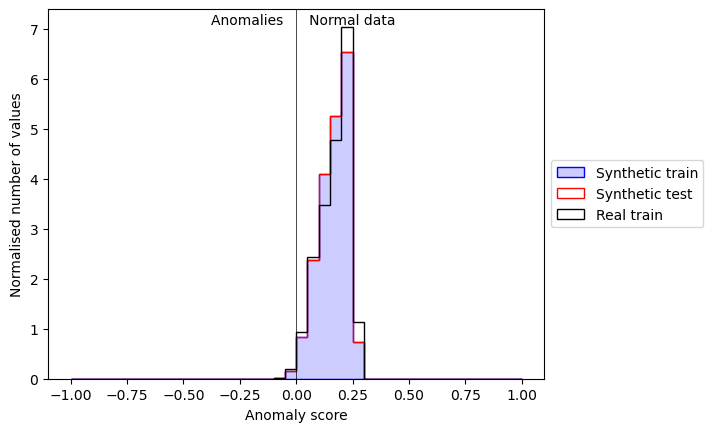

In [27]:
fig, ax = plt.subplots(1, 1) 

bins = np.arange(-1.0, 1.01, 0.05)

ax.hist(X_train_synth_sc_anom_score, bins, density=True, 
        histtype='stepfilled', #hatch='//', 
        color=(0, 0, 1, 0.2), edgecolor=(0, 0, 1, 1),
        label='Synthetic train')
ax.hist(X_test_synth_sc_anom_score, bins, density=True, 
        histtype='step', #hatch='\\\\', 
        color=(1, 0, 0, 0.2), edgecolor=(1, 0, 0, 1),
        label='Synthetic test')


ax.hist(X_train_sc_anom_score, bins, density=True, 
        histtype='step', color='k', 
        label='Real train')

ax.axvline(0.0, color='k', linewidth=0.5)
ax.set_xlabel('Anomaly score')
ax.set_ylabel('Normalised number of values') 
ax.annotate('Anomalies   ', xy=(0.0, ax.get_ylim()[1]*0.95), 
            ha='right', va='bottom') 
ax.annotate('   Normal data', xy=(0.0, ax.get_ylim()[1]*0.95), 
            ha='left', va='bottom') 
ax.legend(loc='center left', bbox_to_anchor=[1.0, 0.5])
plt.show()

This histogram of synthetic data has slight differences from the real data. 

### Separate out the anomalies

The anomalies are where the labels are set to -1, as opposed to normal data with labels of +1.

First we'll have a look at what the anomalous synthetic data looks like: 

In [85]:
# Use the labels from the scaled data to sample the not-scaled data 
# (no "sc" in variable name):
norm_train_synth = X_train_synth[np.where(X_train_synth_labels==+1)]
anom_train_synth = X_train_synth[np.where(X_train_synth_labels==-1)]

df_anom_train_synth = pd.DataFrame(
    anom_train_synth,
    columns=key_features[:-1]    # Exclude S2Thrombolysis 
    )

# df_anom_train_synth

Compare the spread of values of each feature for the anomalous data and the normal data:

In [86]:
for i, feature in enumerate(key_features[:-1]):  # Exclude S2Thrombolysis
    row = np.array([
        feature,
        np.median(norm_train_synth[:,i]),
        np.std(norm_train_synth[:,i]),
        np.median(anom_train_synth[:,i]),
        np.std(anom_train_synth[:,i])
        ])
    if i == 0:
        synth_feature_spreads = row
    else:
        synth_feature_spreads = np.vstack((synth_feature_spreads, row))

df_synth_feature_spreads = pd.DataFrame(
    synth_feature_spreads,
    columns=['Feature', 'Normal median', 'Normal std', 'Anomaly median', 'Anomaly std']
    )

df_synth_feature_spreads

,Feature,Normal median,Normal std,Anomaly median,Anomaly std
0,S2BrainImagingTime_min,29.0,582.460403293346,154.0,4586.11327239734
1,S2StrokeType_Infarction,1.0,0.3541531220678695,0.0,0.4909150892100486
2,S2NihssArrival,6.0,8.135024042965847,11.0,11.932840236410044
3,S1OnsetTimeType_Precise,1.0,0.48313366775641103,0.0,0.4998782656676927
4,S2RankinBeforeStroke,0.0,1.4123820026530767,2.0,1.8213064094922267
5,AFAnticoagulent_Yes,0.0,0.3211347332408983,1.0,0.4779165532455741
6,S1OnsetToArrival_min,100.0,52.55822641105551,119.0,68.2990466464285
7,S1OnsetDateType_Stroke during sleep,0.0,0.1893714645901691,0.0,0.4919090331942699
8,S1AgeOnArrival,77.5,13.663803572678185,72.5,18.14102818291974


^ This isn't very useful as a table. Make a violin (or box and whisker?) insteaD:

In [128]:
def plot_feature_hists(arrays, colours=[(0, 0, 1, 0.2), (1, 0, 0, 0.2)], 
                       edgecolours=[(0, 0, 1, 1), (1, 0, 0, 1)], 
                       labels=['', ''], histtypes=['step', 'step'],
                       savename=''):
    # Figure setup:
    fig, axs = plt.subplots(2, 5, figsize=(15,7), 
                            gridspec_kw={'wspace':0.2, 'hspace':0.4})

    # Histogram bin setup:
    bins_binary = np.arange(-0.5, 2.0, 1.0)
    bins = [    
        np.arange(-7.5, 301.0, 15.0),  # Arrival-to-scan time
        bins_binary,                   # Infarction
        np.arange(-0.5, 43.0, 1.0),    # 'Stroke severity'
        bins_binary,                   # Onset time precise (1=precise, 0=best estimate)
        np.arange(-0.5, 6.5, 1.0),     # Prior disability level
        bins_binary,                   # Use of AF anticoagulents
        np.arange(-7.5, 301.0, 15.0),  # Onset-to-arrival time 
        # 'StrokeTeam',                          # Stroke team, 
        bins_binary,                   # Stroke during sleep (1=yes, 0=no)
        np.arange(0, 120, 5)           # Patient age
        ]

    ax_row = 0
    ax_col = 0 

    for i, feature in enumerate(key_features[:-1]):
        ax = axs[ax_row, ax_col] 

        for j, data in enumerate(arrays):
            ax.hist(data[:,i], bins=bins[i], density=True,
                    color=colours[j], edgecolor=edgecolours[j],#hatch='\\\\',
                    label=labels[j], histtype=histtypes[j])

        # Axis style:
        ax.set_title('\n'.join(feature.split('_')))
        ax.set_yticks([])
        if np.array_equal(bins[i], bins_binary):
            # If this feature is a 0/1 no/yes option:
            ax.set_xticks([0, 1])
            ax.set_xticklabels(['No', 'Yes'])
        if 'Rankin' in feature:
            ax.set_xticks(range(0,6))
        if '_min' in feature:
            ax.set_xticks(np.arange(0.0, bins[i][-1]+(bins[i][-1]-bins[i][-2]), 60))
        if 'Nihss' in feature:
            ax.set_xticks(np.arange(0.0, bins[i][-1]+(bins[i][-1]-bins[i][-2]), 10))
        if ax_col == 2 and ax_row == 1:
            ax.legend(loc='upper center', bbox_to_anchor=[0.5, -0.1], ncol=2)

        # Choose next axis:
        ax_col += 1 
        if ax_col >= 5:
            ax_col = 0
            ax_row += 1

    # Hide unused axes:
    axs[1, 4].set_visible(False)

    if len(savename)>0:
        plt.savefig(savename, dpi=300, bbox_inches='tight')
    plt.show()

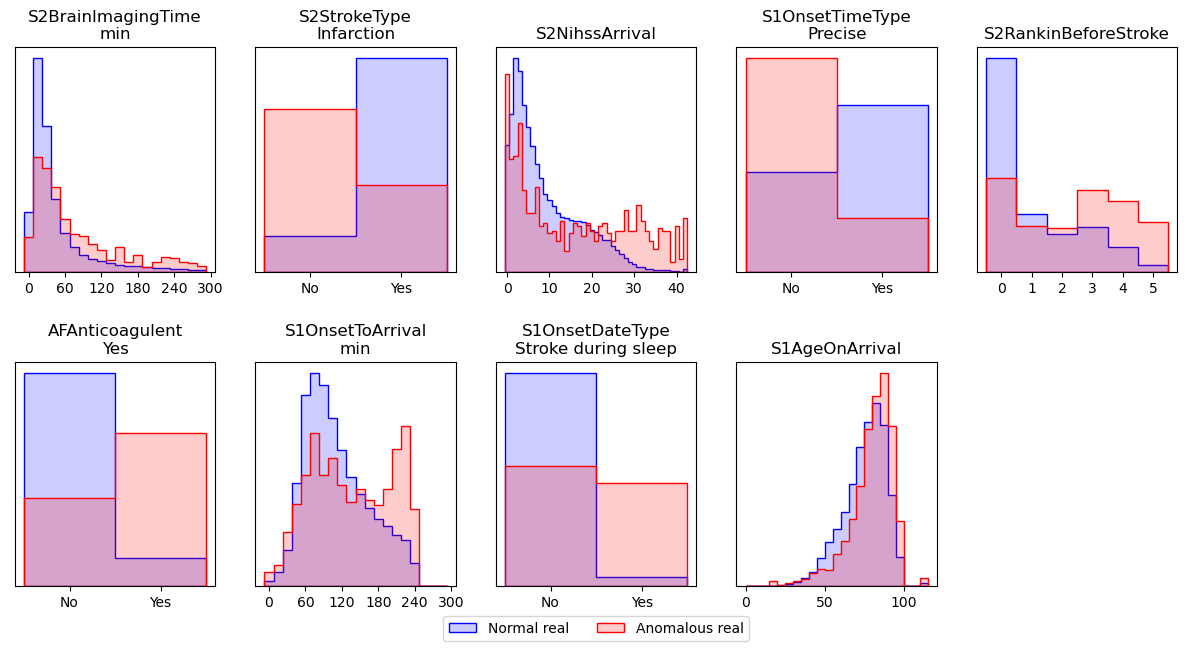

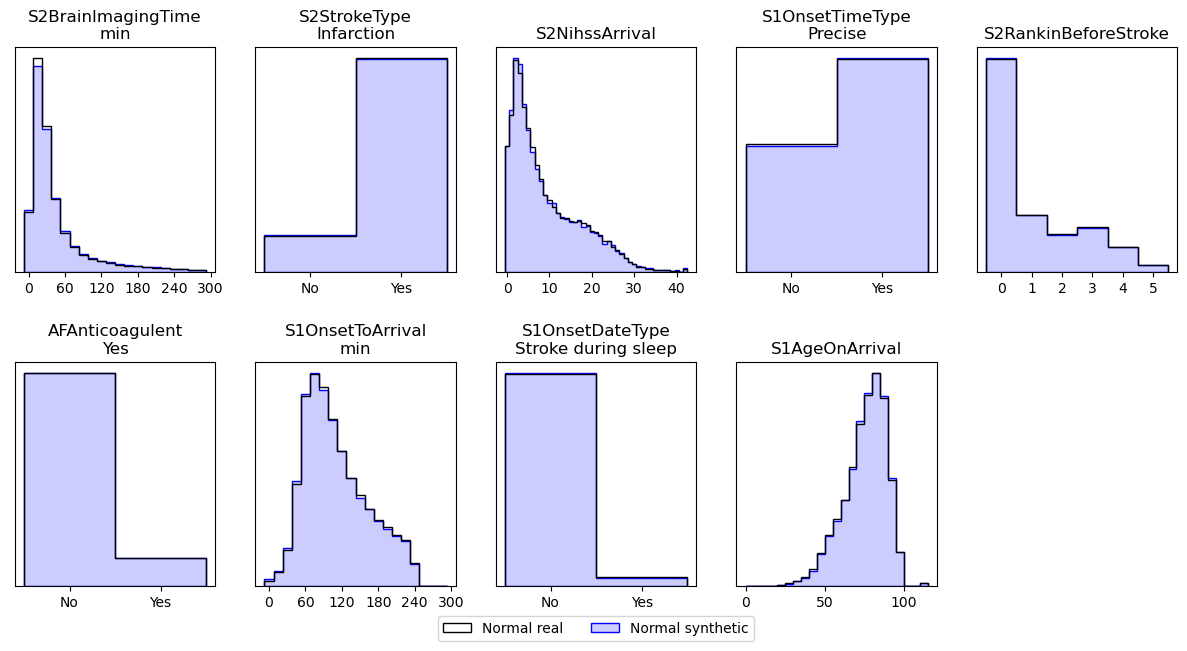

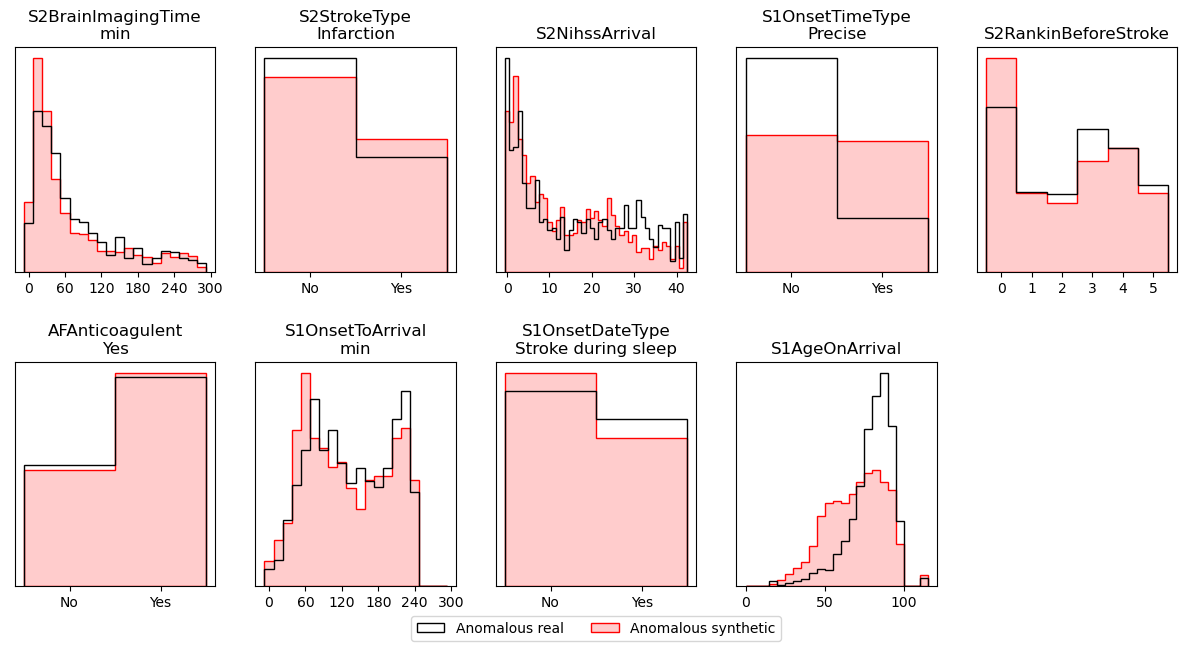

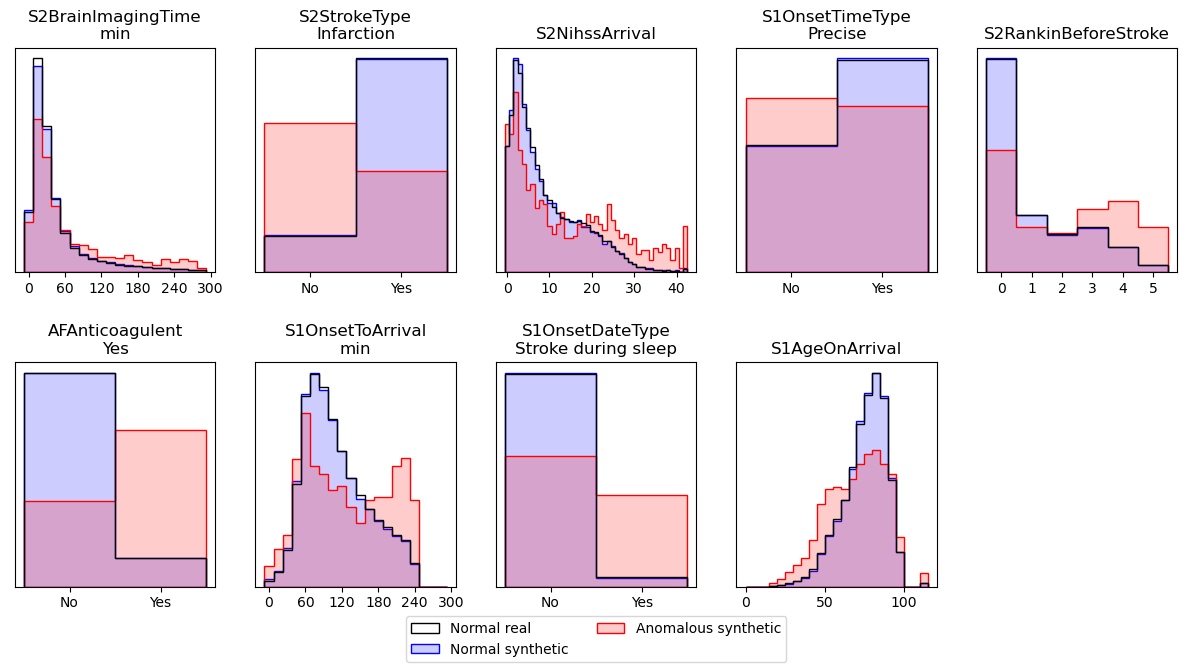

In [130]:
plot_feature_hists([norm_train, anom_train],
                   labels=['Normal real', 'Anomalous real'], 
                   histtypes=['stepfilled', 'stepfilled']
                  )
plot_feature_hists([norm_train, norm_train_synth], 
                   colours=['b', (0, 0, 1, 0.2)], 
                   edgecolours=['k', (0, 0, 1, 1)], 
                   labels=['Normal real', 'Normal synthetic'], 
                   histtypes=['step', 'stepfilled']
                  )
plot_feature_hists([anom_train, anom_train_synth], 
                   colours=['b', (1, 0, 0, 0.2)], 
                   edgecolours=['k', (1, 0, 0, 1)], 
                   labels=['Anomalous real', 'Anomalous synthetic'], 
                   histtypes=['step', 'stepfilled']
                  )
plot_feature_hists([norm_train, norm_train_synth, anom_train_synth], 
                   colours=['b', (0, 0, 1, 0.2), (1, 0, 0, 0.2)], 
                   edgecolours=['k', (0, 0, 1, 1), (1, 0, 0, 1)], 
                   labels=['Normal real', 'Normal synthetic', 
                           'Anomalous synthetic'], 
                   histtypes=['step', 'stepfilled', 'stepfilled'],
                   savename='real_vs_synthetic_hists.pdf'
                  )